In [1]:
## Import relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules.")

Imported modules.


In [2]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the examples
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

In [3]:
# Calculate the Z-scores of each column in the training set:
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Calculate the Z-scores of each column in the test set.
test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

print("Normalized the values.")

Normalized the values.


In [4]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# We scaled all the columns, including latitude and longitude, into their
# Z scores. So, instead of picking a resolution in degrees, we're going
# to use resolution_in_Zs.  A resolution_in_Zs of 1 corresponds to 
# a full standard deviation. 
resolution_in_Zs = 0.3  # 3/10 of a standard deviation.

# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df_norm['latitude'])), 
                                     int(max(train_df_norm['latitude'])), 
                                     resolution_in_Zs))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df_norm['longitude'])), 
                                      int(max(train_df_norm['longitude'])), 
                                      resolution_in_Zs))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, 
                                                longitude_boundaries)

# Create a feature cross of latitude and longitude.
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)  

# Represent median_income as a floating-point value.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Represent population as a floating-point value.
population = tf.feature_column.numeric_column("population")
feature_columns.append(population)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [5]:
def plot_the_loss_curve(epochs, mse):
    """Plot a curve of loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")

    plt.plot(epochs, mse, label="Loss")
    plt.legend()
    plt.ylim([mse.min()*0.95, mse.max() * 1.03])
    plt.show()  

print("Defined the plot_the_loss_curve function.")

#@title Define functions to create and train a linear regression model
def create_model(my_learning_rate, feature_layer):
    """Create and compile a simple linear regression model."""
    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()

    # Add the layer containing the feature columns to the model.
    model.add(feature_layer)

    # Add one linear layer to the model to yield a simple linear regressor.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

    # Construct the layers into a model that TensorFlow can execute.
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

    return model           


def train_model(model, dataset, epochs, batch_size, label_name):
    """Feed a dataset into the model in order to train it."""

    # Split the dataset into features and label.
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

    # Get details that will be useful for plotting the loss curve.
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    rmse = hist["mean_squared_error"]

    return epochs, rmse   

print("Defined the create_model and train_model functions.")

Defined the plot_the_loss_curve function.
Defined the create_model and train_model functions.


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Train on 17000 samples
Epoch 1/15
17000/17000 [==============================] - 0s 23us/sample - loss: 1.0951 - mean_squared_error: 1.0951
Epoch 2/15
17000/17000 [==============================] - 0s 2us/sample - loss: 0.7447 - mean_squared_error: 0.7447
Epoch 3/15
17000/17000 [==============================] - 0s 2us/sample - loss: 0.5612 - mean_squared_error: 0.5612
Epoch 4/15
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4512 - mean_squared_error: 0.4512
Epoch 5/15
17000/17000 [==============================] - 0s 2us/sample - loss: 0.3930 - mean_squared_error: 0.3930
Epoch 6/15
17000/17000 [==============================] - 0s 2us/sample - loss: 0.3693 - mean_squared_error: 0.3693
Epoch 7/15
17000/17000 [========

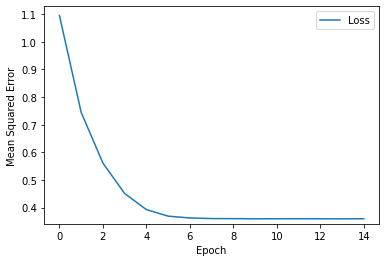


 Evaluate the linear regression model against the test set:
3000/3000 [==============================] - 0s 40us/sample - loss: 0.3954 - mean_squared_error: 0.3954


[0.395366092522939, 0.3953661]

In [6]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "median_house_value"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, mse = train_model(my_model, train_df_norm, epochs, batch_size, label_name)
plot_the_loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

In [46]:
def create_model(my_learning_rate, my_feature_layer):
    """Create and compile a simple linear regression model."""
    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()

    # Add the layer containing the feature columns to the model.
    model.add(my_feature_layer)

    # Describe the topography of the model by calling the tf.keras.layers.Dense
    # method once for each layer. We've specified the following arguments:
    #   * units specifies the number of nodes in this layer.
    #   * activation specifies the activation function (Rectified Linear Unit).
    #   * name is just a string that can be useful when debugging.

    # Define the first hidden layer with 20 nodes.   
    model.add(tf.keras.layers.Dense(units=10, 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.04),
                                    name='Hidden1'))

    # Add Dropout regularization
    # model.add(tf.keras.layers.Dropout(rate=0.25))
    
    
    # Define the second hidden layer with 12 nodes. 
    model.add(tf.keras.layers.Dense(units=6, 
                                    activation='relu',
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.04),
                                    name='Hidden2'))

    # Define the output layer.
    model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

    return model

In [47]:
def train_model(model, dataset, epochs, label_name,
                batch_size=None):
    """Train the model by feeding it data."""

    # Split the dataset into features and label.
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True) 

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # To track the progression of training, gather a snapshot
    # of the model's mean squared error at each epoch. 
    hist = pd.DataFrame(history.history)
    mse = hist["mean_squared_error"]

    return epochs, mse

Train on 17000 samples
Epoch 1/140
17000/17000 [==============================] - 0s 25us/sample - loss: 1.5357 - mean_squared_error: 0.8946
Epoch 2/140
17000/17000 [==============================] - 0s 3us/sample - loss: 0.8642 - mean_squared_error: 0.6196
Epoch 3/140
17000/17000 [==============================] - 0s 3us/sample - loss: 0.6344 - mean_squared_error: 0.4378
Epoch 4/140
17000/17000 [==============================] - 0s 3us/sample - loss: 0.5616 - mean_squared_error: 0.4186
Epoch 5/140
17000/17000 [==============================] - 0s 2us/sample - loss: 0.5204 - mean_squared_error: 0.4039
Epoch 6/140
17000/17000 [==============================] - 0s 3us/sample - loss: 0.4994 - mean_squared_error: 0.3955
Epoch 7/140
17000/17000 [==============================] - 0s 3us/sample - loss: 0.4851 - mean_squared_error: 0.3890
Epoch 8/140
17000/17000 [==============================] - 0s 3us/sample - loss: 0.4760 - mean_squared_error: 0.3857
Epoch 9/140
17000/17000 [===============

17000/17000 [==============================] - 0s 2us/sample - loss: 0.3989 - mean_squared_error: 0.3556
Epoch 71/140
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4002 - mean_squared_error: 0.3564
Epoch 72/140
17000/17000 [==============================] - 0s 2us/sample - loss: 0.3972 - mean_squared_error: 0.3536
Epoch 73/140
17000/17000 [==============================] - 0s 2us/sample - loss: 0.3968 - mean_squared_error: 0.3538
Epoch 74/140
17000/17000 [==============================] - 0s 2us/sample - loss: 0.3974 - mean_squared_error: 0.3553
Epoch 75/140
17000/17000 [==============================] - 0s 2us/sample - loss: 0.3950 - mean_squared_error: 0.3517
Epoch 76/140
17000/17000 [==============================] - 0s 2us/sample - loss: 0.3950 - mean_squared_error: 0.3527
Epoch 77/140
17000/17000 [==============================] - 0s 2us/sample - loss: 0.3959 - mean_squared_error: 0.3536
Epoch 78/140
17000/17000 [==============================] - 0s 2us/sa

17000/17000 [==============================] - 0s 3us/sample - loss: 0.3808 - mean_squared_error: 0.3463
Epoch 140/140
17000/17000 [==============================] - 0s 3us/sample - loss: 0.3809 - mean_squared_error: 0.3466


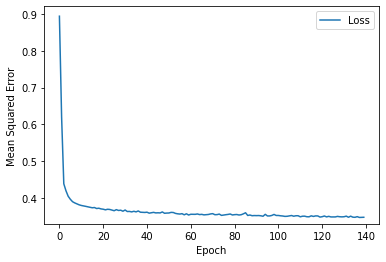


 Evaluate the new model against the test set:
3000/3000 [==============================] - 0s 59us/sample - loss: 0.4143 - mean_squared_error: 0.3808


[0.41431424021720886, 0.38081568]

In [49]:
# The following variables are the hyperparameters.
learning_rate = 0.007
epochs = 140
batch_size = 1000

# Specify the label
label_name = "median_house_value"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined by the feature_layer.
epochs, mse = train_model(my_model, train_df_norm, epochs, 
                          label_name, batch_size)
plot_the_loss_curve(epochs, mse)

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)